We are trying to explain the reason why there is difference in space and time with the baseline. Is it chance ? Or is it specific to space 
or time ?

In [114]:
import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks/')

import sqlite3
import pandas as pd
pd.options.mode.chained_assignment = None

import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph_leiden
from functions.datamodel import OptimumParameter
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats

#from region_filters import columns_eu_unique, columns_non_eu_unique
from optimal_clustering import optimal_clustering

pd.options.mode.chained_assignment = None

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

import warnings
# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from functions.env import DB_SCIENCE_PATH_NEW

In [115]:
# 1-get the jaccard similarity between all the differnet regions and a sampling of the regions of the same size

In [116]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [117]:
matrix_baseline = pd.read_csv('../networks/matrix/weighted_optimized_before_1700.csv', index_col = [0])
matrix_baseline = matrix_baseline[['source', 'target', 'weight']]
matrix_baseline['weight'] = (matrix_baseline['weight'] - matrix_baseline['weight'].min()) / (matrix_baseline['weight'].max() - matrix_baseline['weight'].min())

matrix_baseline

,source,target,weight
0,zoologist,botanist,0.056995
1,zoologist,mathematician,0.041451
2,zoologist,historian,0.025907
3,zoologist,physicist,0.020725
4,zoologist,astronomer,0.020725
...,...,...,...
289,anatomist,geographer,0.005181
290,anatomist,chemist,0.000000
291,anatomist,zoologist,0.000000
292,anatomist,anthropologist,0.000000


In [118]:
df_regions = pd.read_csv('../networks/data/global_before_1700.csv', index_col = [0])
df_regions['meta_occupation']=df_regions['meta_occupation'].apply(lambda x : x.split(' | '))
df_regions = df_regions.explode('meta_occupation')
df_regions = df_regions.reset_index(drop=True)

In [119]:
import numpy as np

def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2

def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity

In [120]:
df_sample = df_regions[df_regions['region_name']=='Japan']
df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
len_individuals = len(set(df_sample['wikidata_id']))
df_sample.columns = ["source", "target"]
df_sample["weight"] = 1
df_sample

,source,target,weight
4971,Q6538434,mathematician,1
4972,Q786877,astronomer,1
4973,Q6538396,astronomer,1
4974,Q11389078,astronomer,1
4975,Q6538534,mathematician,1
4976,Q4067901,botanist,1
4977,Q1150151,astronomer,1
4978,Q369158,philosopher,1
4979,Q369158,linguist,1
4980,Q369158,political scientist,1


In [121]:
min_individuals = 0

final_list = []
for region in list(set(df_regions['region_name'])):
#for region in ['Japan']:

    df_sample = df_regions[df_regions['region_name']==region]

    """
    # count number of individuals with at least two occupations
    count_duplicate = df_sample[df_sample['region_code']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region)

    if duplicate_counts <min_individuals:
        continue
        
    """

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())

    matrix1, matrix2 = prepare_edge_list(df_edge, matrix_baseline)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('score', ascending=False)

Display the distance, add a regresion line and add labels

In [122]:
final_df = final_df.sort_values('sample_length', ascending=False)
final_df

,sample_length,score,region
1,890,0.528274,German world
15,678,0.619984,Italy
12,608,0.467894,France
6,345,0.443272,Low countries
11,251,0.544863,Central Europe
4,191,0.299760,Spain
5,171,0.555622,Arabic world
13,121,0.526834,Chinese world
3,111,0.500938,Greek World
2,73,0.600910,Persian world


## plot with labels

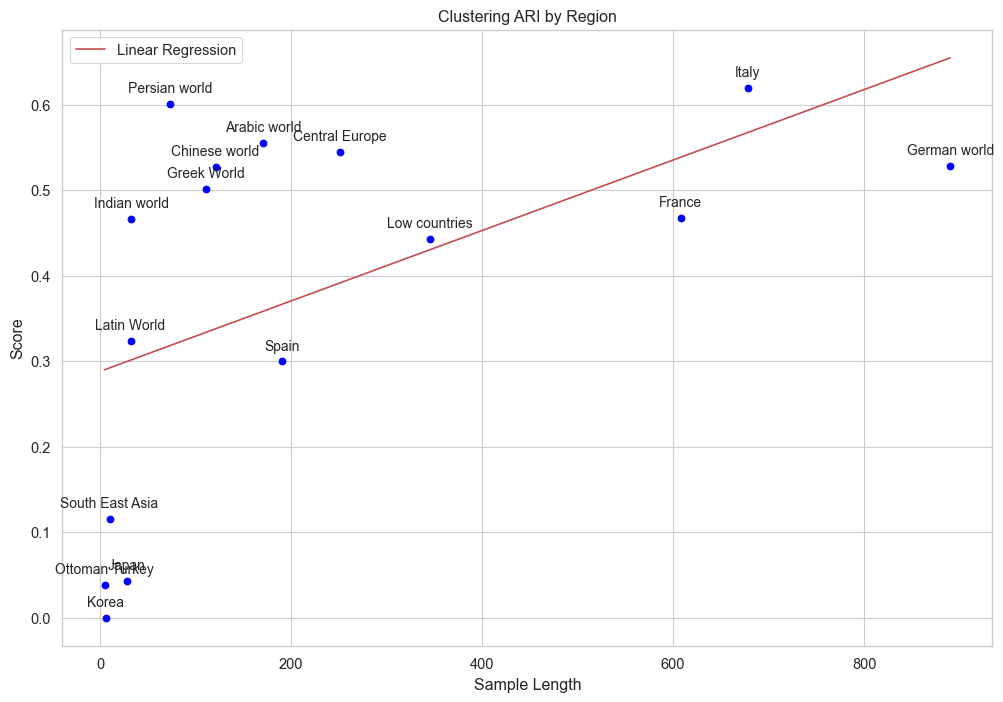

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

sample_lengths = [entry for entry in final_df['sample_length']]
ari_values = [entry for entry in final_df['score']]
regions = [entry for entry in final_df['region']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, region in enumerate(regions):
    plt.text(sample_lengths[i], ari_values[i]+0.01, region, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Sample Length')
plt.ylabel('Score')
plt.title('Clustering ARI by Region')
plt.grid(True)

# Linear regression
X = final_df[['sample_length']]
y = final_df['score']

X = sm.add_constant(X)  # Adding a constant term to the predictor
model = sm.OLS(y, X).fit()

# Get the p-value from the model summary
p_value = model.pvalues[1]

y_pred = model.predict(X)
plt.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

# Display p-value on the plot
#plt.text(7000, 0.6, f'p-value = {p_value:.4f}', fontsize=12, color='green')

plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.show()

Compute the same analysis with fake sample of the size of the countries

In [124]:
list(set(df_regions.region_code))

['re_france',
 're_greek_world',
 're_italy',
 're_indian_world',
 're_spain',
 're_chinese_world',
 're_south_east_asia',
 're_arabic_world',
 're_central_europe',
 're_japan',
 're_persian_world',
 're_latin',
 're_ottoman_turkey',
 're_german_world',
 're_korea',
 're_low_countries']

In [125]:

final_list = []
list_individuals = list(set(df_regions.wikidata_id))
for region in list(set(df_regions['region_code'])):
    df_region_filter = df_regions[df_regions['region_code']==region]
    len_ind_region = len(set(df_region_filter['wikidata_id']))
    

    # count number of individuals with at least two occupations
    count_duplicate = df_region_filter[df_region_filter['region_code']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
    

    random.seed(42)
    list_individuals_sample = random.sample(list_individuals, len_ind_region)
    df_sample = df_regions[df_regions['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    len_individuals = len(set(df_sample['wikidata_id']))


    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())

    matrix1, matrix2 = prepare_edge_list(df_edge, matrix_baseline)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})


final_df_sample = pd.DataFrame(final_list)

final_df_sample['region'] = final_df_sample['region'] + '_sample'
final_df_sample = final_df_sample.rename(columns = {'score':'score_sample', 'region':'region_sample'})
df_plot = pd.merge(final_df, final_df_sample, on = 'sample_length')


re_france 201
re_greek_world 80
re_italy 242
re_indian_world 20
re_spain 54
re_chinese_world 59
re_south_east_asia 3
re_arabic_world 93
re_central_europe 97
re_japan 3
re_persian_world 43
re_latin 20
re_ottoman_turkey 3
re_german_world 316
re_korea 0
re_low_countries 118


#### Plot Both

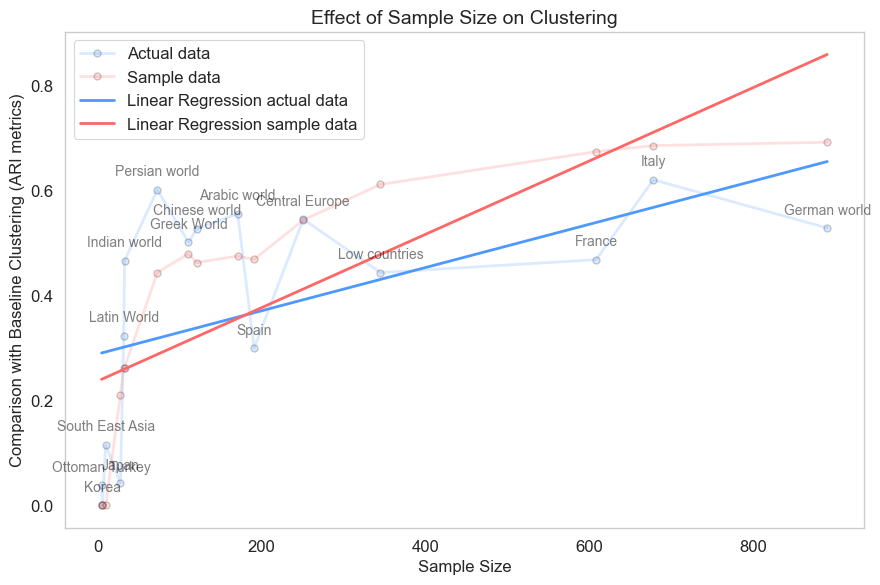

In [126]:
# Separate 'ari' and 'ari_sample' values into two lists
df_plot = df_plot.sort_values('sample_length')
ari_values = df_plot['score']
ari_sample_values = df_plot['score_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05

# Extracting data from the DataFrame
sample_length = df_plot['sample_length']
ari = df_plot['score']
ari_sample = df_plot['score_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['score'], label='score', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)


# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['score_sample'], label='score_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['sample_length'], df_plot['score'], df_plot['score_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['sample_length'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}*)"])

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

### Plot the logs

In [127]:
df_plot[['score', 'score_sample']].corr()

,score,score_sample
score,1.000000,0.846364
score_sample,0.846364,1.000000


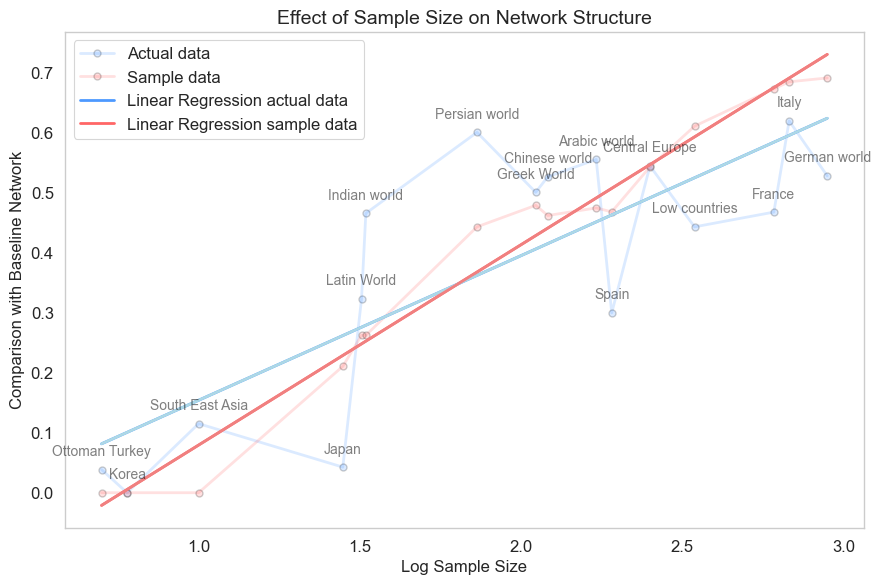

In [158]:
# Extracting data from the DataFrame
sample_length = np.log10(df_plot['sample_length'])
ari = df_plot['score']
ari_sample = df_plot['score_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']
df_plot['log_size'] = np.log10(df_plot['sample_length'])

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['score'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['score_sample'], label='score_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network', fontsize=12)
ax.set_title('Effect of Sample Size on Network Structure', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['log_size'], df_plot['score'], df_plot['score_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

    
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

# Get coefficients instead of p-values
coeff_1 = round(model.params[1], 3)
coeff_2 = round(model_2.params[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model.predict(X), color='lightblue', label=f'Linear Regression (Coeff: {coeff_1})', linewidth=2)
plt.plot(df_plot['log_size'], model_2.predict(X), color='lightcoral', label=f'Linear Regression (Coeff: {coeff_2})', linewidth=2)


ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                            #f'Linear Regression (Coeff: {coeff_1})',
                                            #f'Linear Regression (Coeff: {coeff_2})'])


    # Set new x-axis tick positions and labels
#new_xticks = list(df_plot['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)
# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()


### Baseline Century

In [138]:
df_time = df_regions.copy()
df_time['time'] = df_regions['birthyear'].apply(lambda year: round(year, -2))
df_time = df_time[['wikidata_id', 'meta_occupation', 'time']].copy()
df_time

,wikidata_id,meta_occupation,time
0,Q50082878,physicist,0.0
1,Q723645,astronomer,400.0
2,Q723645,mathematician,400.0
3,Q297515,historian,0.0
4,Q297515,geographer,0.0
...,...,...,...
5609,Q167852,mathematician,700.0
5610,Q11362,philosopher,1100.0
5611,Q11362,astronomer,1100.0
5612,Q11362,botanist,1100.0


In [141]:
final_list = []
#for time in [600]:
for time in sorted(list(set(df_time.time))):

    df_sample = df_time[df_time['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    

    """
     # count number of individuals with at least two occupations
    duplicate_counts = df_sample['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
        
    """

    len_individuals = len(set(df_sample['wikidata_id']))
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())

    matrix1, matrix2 = prepare_edge_list(df_edge, matrix_baseline)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'time':time})

final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time['log_size'] = np.log10(final_df_time['sample_length']+1)
final_df_time

,sample_length,score,time,log_size
0,1,0.393782,-800.0,0.301030
1,9,0.435254,-600.0,1.000000
2,18,0.302249,-500.0,1.278754
3,25,0.433476,-400.0,1.414973
4,17,0.455508,-300.0,1.255273
5,14,0.386428,-200.0,1.176091
6,18,0.422253,-100.0,1.278754
7,12,0.428266,0.0,1.113943
8,16,0.482859,100.0,1.230449
9,17,0.477657,200.0,1.255273


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


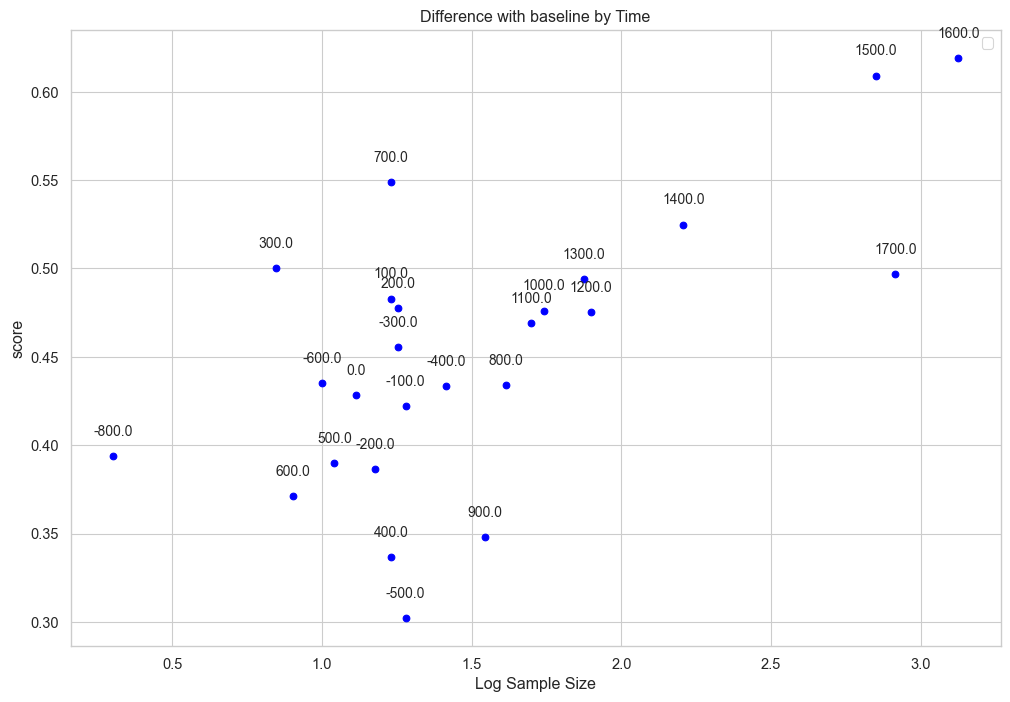

<Figure size 640x480 with 0 Axes>

In [142]:
sample_lengths = [entry for entry in final_df_time['log_size']]
ari_values = [entry for entry in final_df_time['score']]
times = [entry for entry in final_df_time['time']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, time in enumerate(times):
    plt.text(sample_lengths[i], ari_values[i]+0.01, time, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Log Sample Size')
plt.ylabel('score')
plt.title('Difference with baseline by Time')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

In [150]:
import random

list_individuals = list(set(df_time.wikidata_id))

final_list = []
for time in list(set(df_time['time'])):


    df_time_filter = df_time[df_time['time']==time]
    len_ind_time = len(set(df_time_filter['wikidata_id']))
    
    """
    
        # count number of individuals with at least two occupations
    duplicate_counts = df_time_filter['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
        
    """

    random.seed(42)
    list_individuals_sample = random.sample(list_individuals, len_ind_time)
    df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    len_individuals = len(set(df_sample['wikidata_id']))

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())

    matrix1, matrix2 = prepare_edge_list(df_edge, matrix_baseline)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'time':time})


final_df_time_sample = pd.DataFrame(final_list)
final_df_time_sample = final_df_time_sample.sort_values('sample_length')

final_df_time_sample = final_df_time_sample.rename(columns = {'score':'score_sample', 'time':'time_sample'})
df_plot_sample = pd.merge(final_df_time_sample, final_df_time, on = ['sample_length'])

df_plot_sample['log_size'] = np.log10(df_plot_sample['sample_length']+1)
df_plot_sample = df_plot_sample[df_plot_sample['sample_length']>10]

,sample_length,score_sample,time_sample,score,time,log_size
5,12,0.010363,0.0,0.428266,0.0,1.113943
6,14,0.266150,-200.0,0.386428,-200.0,1.176091
7,16,0.515306,100.0,0.482859,100.0,1.230449
8,16,0.515306,100.0,0.336550,400.0,1.230449
9,16,0.515306,100.0,0.548756,700.0,1.230449
10,16,0.515306,700.0,0.482859,100.0,1.230449
11,16,0.515306,700.0,0.336550,400.0,1.230449
12,16,0.515306,700.0,0.548756,700.0,1.230449
13,16,0.515306,400.0,0.482859,100.0,1.230449
14,16,0.515306,400.0,0.336550,400.0,1.230449


Plot the T statistics

In [152]:

ari_values = df_plot_sample['score']
ari_sample_values = df_plot_sample['score_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

2.1090859058948537

In [153]:
df_plot_sample[['score_sample', 'score']].corr()

,score_sample,score
score_sample,1.000000,0.475926
score,0.475926,1.000000


0.00302
0.00036


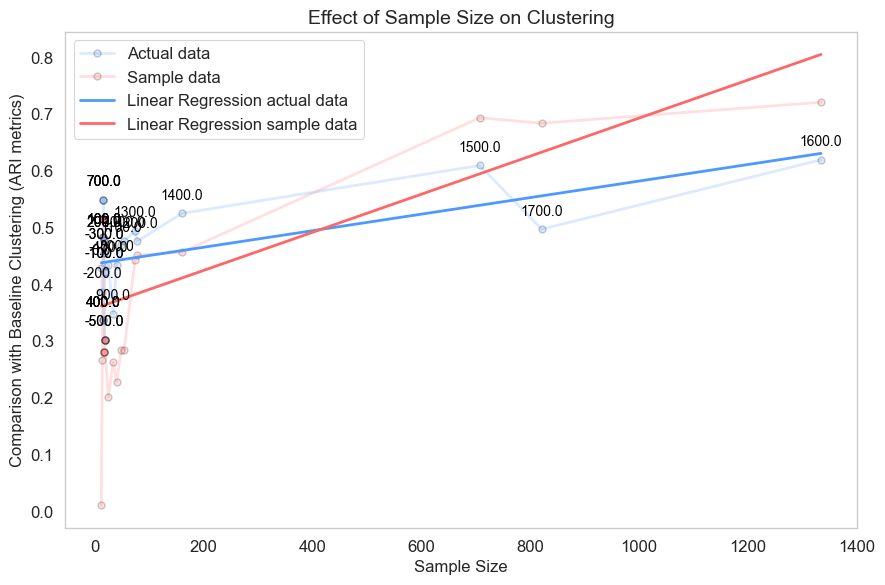

In [154]:
# Extracting data from the DataFrame
sample_length = df_plot_sample['sample_length']
ari = df_plot_sample['score']
ari_sample = df_plot_sample['score_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['score'], label='score', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['score_sample'], label='score_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)



# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['sample_length'], df_plot_sample['score'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['sample_length']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['sample_length'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])




plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
from sklearn.linear_model import RANSACRegressor

,sample_length,score_sample,time_sample,score,time,log_size
5,12,0.010363,0.0,0.428266,0,1.113943
6,14,0.266150,-200.0,0.386428,-200,1.176091
7,16,0.515306,100.0,0.482859,100,1.230449
8,16,0.515306,100.0,0.336550,400,1.230449
9,16,0.515306,100.0,0.548756,700,1.230449
10,16,0.515306,700.0,0.482859,100,1.230449
11,16,0.515306,700.0,0.336550,400,1.230449
12,16,0.515306,700.0,0.548756,700,1.230449
13,16,0.515306,400.0,0.482859,100,1.230449
14,16,0.515306,400.0,0.336550,400,1.230449


0.00196
0.00126


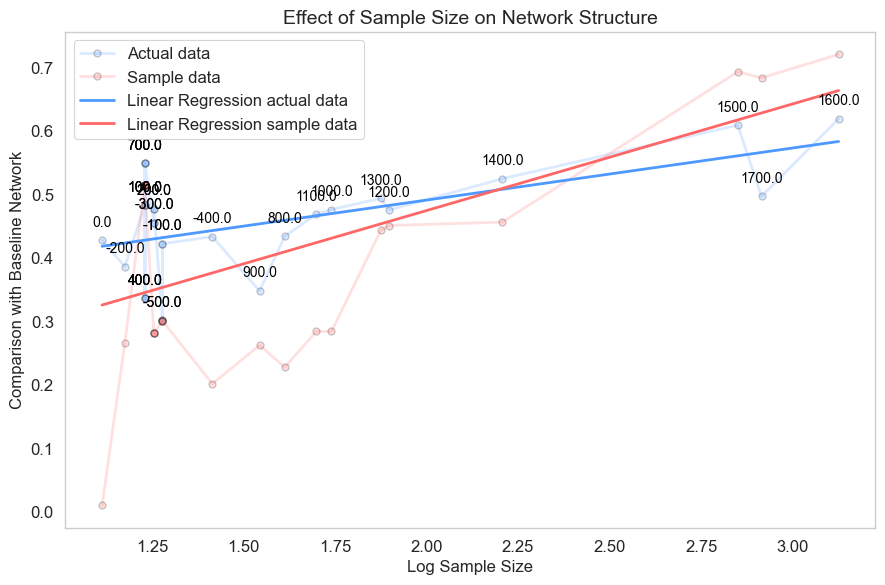

In [159]:
df_plot_sample['time'] = df_plot_sample['time'].astype(int)

import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for improved style

# Extracting data from the DataFrame
log_size = df_plot_sample['log_size']
ari = df_plot_sample['score']
ari_sample = df_plot_sample['score_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['log_size'], df_plot_sample['score'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['log_size'], df_plot_sample['score_sample'], label='score_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network', fontsize=12)
ax.set_title('Effect of Sample Size on Network Structure', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['log_size'], df_plot_sample['score'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['log_size']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)


model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['log_size'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ]) 
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()